In [8]:
import os
import pickle
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize
import traceback
import matplotlib.gridspec as gridspec
import StellarDMTracing as sdt
import PlotClasses

import sys
import os
import importlib
sys.path.append('/home/bk639/MorphologyMeasurements/Code')

'''
Obviously  need SimInfo pickles from Config_dir
Update the newest Merians from update_merians.ipynb
what needs to be run to make this work
Reff and Profiles from ImageCollection, dont think I need to run isophote masking, except maybe for x00y00
StShapes, DMShapes from 3DShapes
smoothed shapes from 3DShapesSmoothing
halotypes from halotypes.py, in the case of Merians they are all simply centrals
masses from get_masses.py
try/except blocks should catch any mismatches, so don't need to worry too much about everything being perfect. 
'''
    


feedbacks = ['BWMDC', 'MerianCDM']
#feedbacks = [ 'MerianCDM']



In [9]:
def T(ba,ca):
    return( (1-ba**2)/(1-ca**2) )

def perform_ks_tests(B_s, B_d, C_s, C_d, mask=None):
        if mask is None:
            mask = np.ones_like(B_s, dtype=bool)

        # Perform KS tests
        ks_B = stats.ks_2samp(B_s[mask], B_d[mask])
        ks_C = stats.ks_2samp(C_s[mask], C_d[mask])

        return {
            'B_statistic': ks_B.statistic,
            'B_pvalue': ks_B.pvalue,
            'C_statistic': ks_C.statistic,
            'C_pvalue': ks_C.pvalue
        }




In [14]:
#disk classifcation by shape at 2Reff
importlib.reload(sdt)
feedbacks = ['BWMDC', 'MerianCDM']
for reff_multi in [2]:
    B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,mb_reff,mb_10rvir,htype,reff,mvir,feedback_type,sims,hids,mergers,rvir,diffs_at_reff, jz_jcirc_avgs,t_dyn = sdt.LoadSimData(feedbacks,return_sims=True,reff_multi=reff_multi)



    #recreate disk_mask for galaxies where C_s < 0.4, and B_s > 0.65
    #try variations of this mask +- 0.05
    C_thresh = 0.4
    B_thresh = 0.65
    mask = (C_s < C_thresh) & (B_s > B_thresh)
    disks_mask = mask
    ellip_mask = ~mask

    #print number of galaxies on the border +- 0.05
    #start with the larger box B_s = 0.7, C_s = 0.45
    mask_l = (C_s < C_thresh + 0.05) & (B_s > B_thresh - 0.05)
    mask_s = (C_s < C_thresh - 0.05) & (B_s > B_thresh + 0.05)
    #count number of galaxies in each the larger box but are not in the smaller box
    print(f'number of galaxies in larger box but not in smaller box: {sum(mask_l & ~mask_s)}')
    
    #print sim and halo ids of galaxies in the larger box but not in the smaller box
    for i in range(len(sims)):
        if mask_l[i] and not mask_s[i]:
            print(f'sims: {sims[i]}, hids: {hids[i]}')
            print(f'{B_s[i]:.2f}, {C_s[i]:.2f}')
    


    #compare to old method
    #print(f'number in sample at reff_multi {reff_multi}: {len(sims)}')
    disk_sims = {}
    for feedback in feedbacks:
        # with open(f'galaxy_classifications_{feedback}.pickle', 'wb') as f:
        #     pickle.dump(classified_galaxies, f)
        try:
            with open(f'galaxy_classifications_{feedback}.pickle', 'rb') as f:
                classified_galaxies = pickle.load(f)
                disk_sims.update(classified_galaxies)
        except FileNotFoundError:
            print(f'File galaxy_classifications_{feedback}.pickle not found')
            continue


    #combine all classified galaxies


    mask = np.zeros(len(sims), dtype=bool)
    disk_mask = np.zeros(len(sims), dtype=bool)
    ellip_mask = np.zeros(len(sims), dtype=bool)
    irr_mask = np.zeros(len(sims), dtype=bool)

    for sim in disk_sims:
        for halo in disk_sims[sim]:
            disk_sim = disk_sims[sim][halo]
            # Find indices where both sims and hids match the current sim and halo
            indices = (sims == sim) & (hids == halo)
            #print(sim, halo, disk_sim)
            # if masses[indices] < 7.5:
            #     disk_sim = 'e'
            if disk_sim == 'd':
                disk_mask[indices] = True
            elif disk_sim == 'i':
                irr_mask[indices] = True
            elif disk_sim == 'e':
                ellip_mask[indices] = True
            else:
                print('Error: disk_sim not recognized')
                print(sim, halo)
                print(disk_sim)
                break
    n_diff = 0
    for i in range(len(sims)):
        if disks_mask[i] != disk_mask[i]:
            # print(f'sims: {sims[i]}, hids: {hids[i]}, new: {disks_mask[i]}, old: {disk_mask[i]}')
            # print(f'C_s: {C_s[i]}, T_s: {T_s[i]}')
            n_diff += 1
    print(f'number of differences at reff_multi {reff_multi}: {n_diff}')
    
    #print sims with c_s < .4, and t_s > .666
    for i in range(len(sims)):
        if C_s[i] < .4 and T_s[i] > .666:
            print(f'sims: {sims[i]}, hids: {hids[i]}, C_s: {C_s[i]:.2f}, B_s: {B_s[i]:.2f}, T_s: {T_s[i]:.2f}, mass {masses[i]:.2f}')

disk_mask = None
ellip_mask = None
irr_mask = None


['../PickleFiles/SimulationInfo.BWMDC.pickle', '../PickleFiles/SimulationInfo.MerianCDM.pickle']
number of galaxies in larger box but not in smaller box: 11
sims: cptmarvel, hids: 3
0.63, 0.39
sims: elektra, hids: 3
0.60, 0.35
sims: storm, hids: 3
0.81, 0.35
sims: storm, hids: 8
0.66, 0.41
sims: rogue, hids: 11
0.85, 0.40
sims: h148, hids: 2
0.66, 0.36
sims: r615, hids: 1
0.62, 0.36
sims: r634, hids: 1
0.68, 0.18
sims: r753, hids: 1
0.84, 0.44
sims: r916, hids: 1
0.70, 0.35
sims: r918, hids: 1
0.87, 0.42
number of differences at reff_multi 2: 21
sims: cptmarvel, hids: 3, C_s: 0.39, B_s: 0.63, T_s: 0.71, mass 6.93
sims: elektra, hids: 3, C_s: 0.35, B_s: 0.60, T_s: 0.73, mass 7.60
sims: elektra, hids: 4, C_s: 0.39, B_s: 0.48, T_s: 0.91, mass 7.78
sims: r563, hids: 1, C_s: 0.34, B_s: 0.59, T_s: 0.73, mass 8.61
sims: r615, hids: 1, C_s: 0.36, B_s: 0.62, T_s: 0.71, mass 9.47
sims: r716, hids: 1, C_s: 0.39, B_s: 0.53, T_s: 0.84, mass 8.14


['../PickleFiles/SimulationInfo.BWMDC.pickle', '../PickleFiles/SimulationInfo.MerianCDM.pickle']

All data:
B: statistic=0.35, p-value=9.59e-05
C: statistic=0.62, p-value=5.97e-15

non-disky galaxies:
B: statistic=0.24, p-value=1.45e-01
C: statistic=0.43, p-value=2.76e-04

disky galaxies:
B: statistic=0.50, p-value=3.16e-04
C: statistic=0.97, p-value=4.78e-18
number of disk galaxies at reff_multi 1: 34
number of non-disk galaxies at reff_multi 1: 46
plot_KF_data
True
False
KF Low Mass non-disky: 14/46 points within ellipse
KF Low Mass disky: 0/34 points within ellipse
KF Medium Mass non-disky: 1/46 points within ellipse
KF Medium Mass disky: 10/34 points within ellipse
KF High Mass non-disky: 1/46 points within ellipse
KF High Mass disky: 11/34 points within ellipse


/home/bk639/miniconda3/envs/pynbody_beta/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges



Analysis for non-disky - Q_*:

Statistics:
Mean: 0.749
Std: 0.146
Residual Std: 0.136
Slope: -0.059 ± 0.022
Intercept: 1.207
R²: 0.133

Analysis for non-disky - S_*:

Statistics:
Mean: 0.542
Std: 0.140
Residual Std: 0.127
Slope: -0.064 ± 0.020
Intercept: 1.044
R²: 0.175

Analysis for disky - Q_*:

Statistics:
Mean: 0.775
Std: 0.115
Residual Std: 0.115
Slope: 0.006 ± 0.039
Intercept: 0.728
R²: 0.001

Analysis for disky - S_*:

Statistics:
Mean: 0.282
Std: 0.063
Residual Std: 0.057
Slope: -0.049 ± 0.019
Intercept: 0.705
R²: 0.162

Analysis for non-disky - Q_DM/Q_*:

Statistics:
Mean: 1.115
Std: 0.153
Residual Std: 0.139
Slope: 0.070 ± 0.023
Intercept: 0.564
R²: 0.176

Analysis for non-disky - S_DM/S_*:

Statistics:
Mean: 1.291
Std: 0.252
Residual Std: 0.204
Slope: 0.162 ± 0.033
Intercept: 0.026
R²: 0.344

Analysis for disky - Q_DM/Q_*:

Statistics:
Mean: 1.167
Std: 0.131
Residual Std: 0.131
Slope: 0.017 ± 0.044
Intercept: 1.025
R²: 0.004

Analysis for disky - S_DM/S_*:

Statistics:
Mean

/home/bk639/miniconda3/envs/pynbody_beta/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges



Analysis for non-disky - Q_*:

Statistics:
Mean: 0.764
Std: 0.150
Residual Std: 0.149
Slope: -0.021 ± 0.024
Intercept: 0.926
R²: 0.016

Analysis for non-disky - S_*:

Statistics:
Mean: 0.543
Std: 0.131
Residual Std: 0.125
Slope: -0.042 ± 0.020
Intercept: 0.875
R²: 0.088

Analysis for disky - Q_*:

Statistics:
Mean: 0.850
Std: 0.076
Residual Std: 0.076
Slope: -0.020 ± 0.026
Intercept: 1.018
R²: 0.017

Analysis for disky - S_*:

Statistics:
Mean: 0.265
Std: 0.061
Residual Std: 0.056
Slope: -0.051 ± 0.019
Intercept: 0.700
R²: 0.178

Analysis for non-disky - Q_DM/Q_*:

Statistics:
Mean: 1.063
Std: 0.104
Residual Std: 0.099
Slope: 0.033 ± 0.016
Intercept: 0.802
R²: 0.086

Analysis for non-disky - S_DM/S_*:

Statistics:
Mean: 1.204
Std: 0.171
Residual Std: 0.139
Slope: 0.108 ± 0.023
Intercept: 0.360
R²: 0.333

Analysis for disky - Q_DM/Q_*:

Statistics:
Mean: 1.099
Std: 0.094
Residual Std: 0.094
Slope: 0.013 ± 0.032
Intercept: 0.986
R²: 0.005

Analysis for disky - S_DM/S_*:

Statistics:
Mea

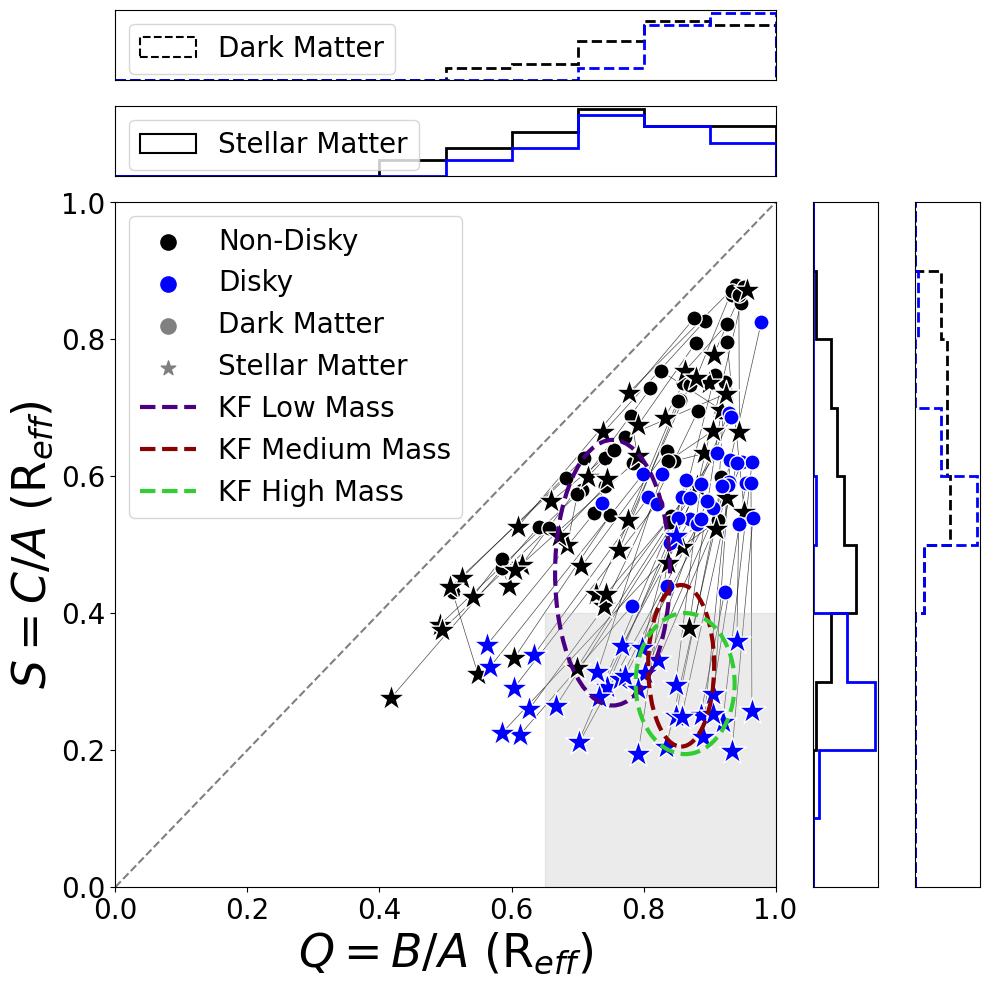

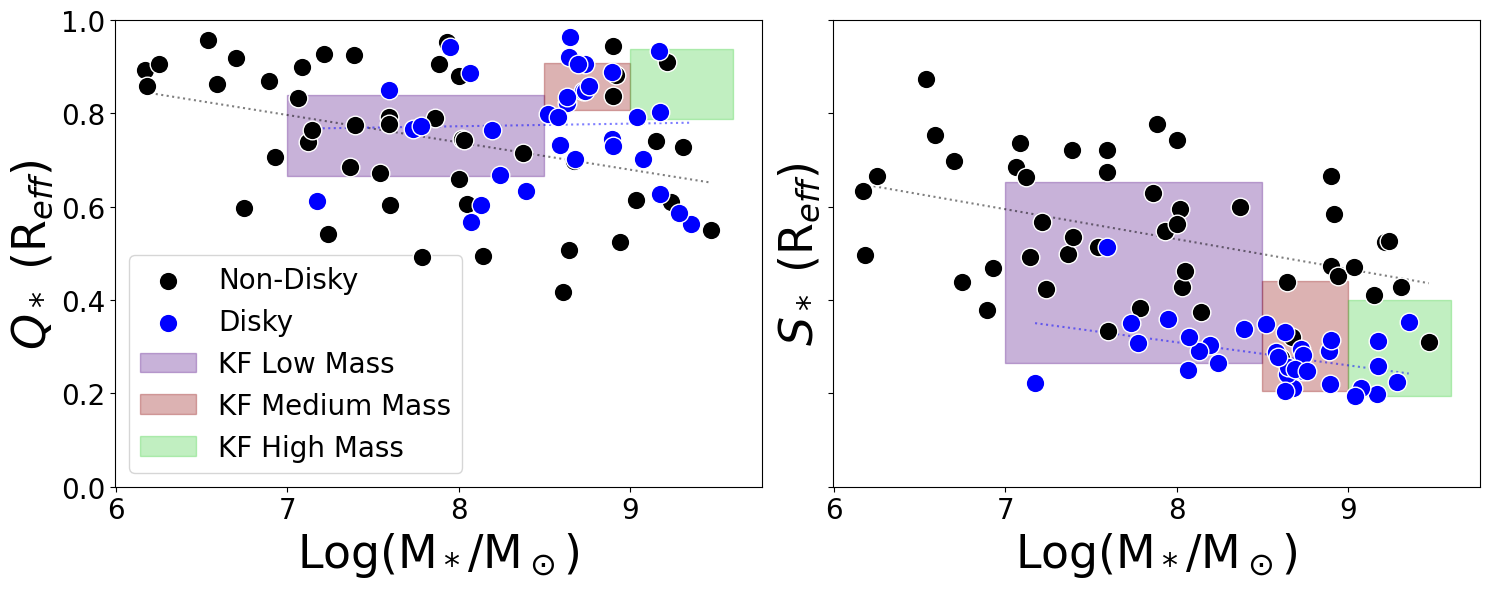

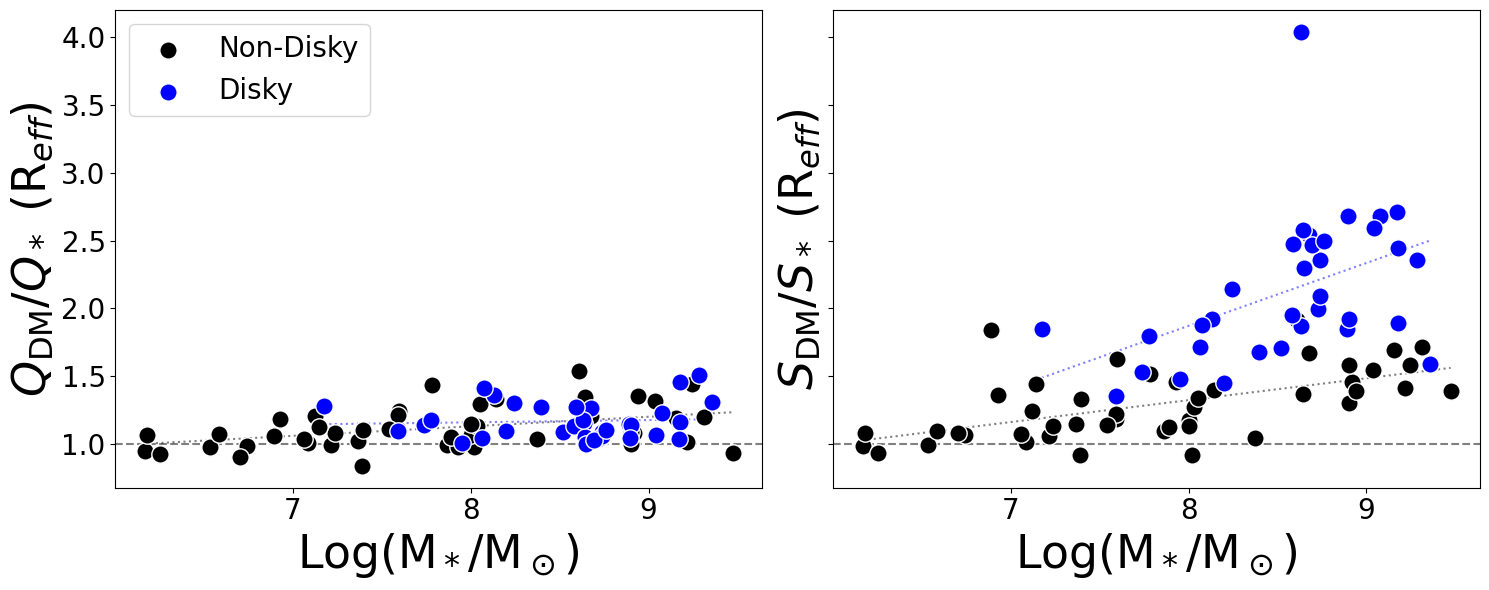

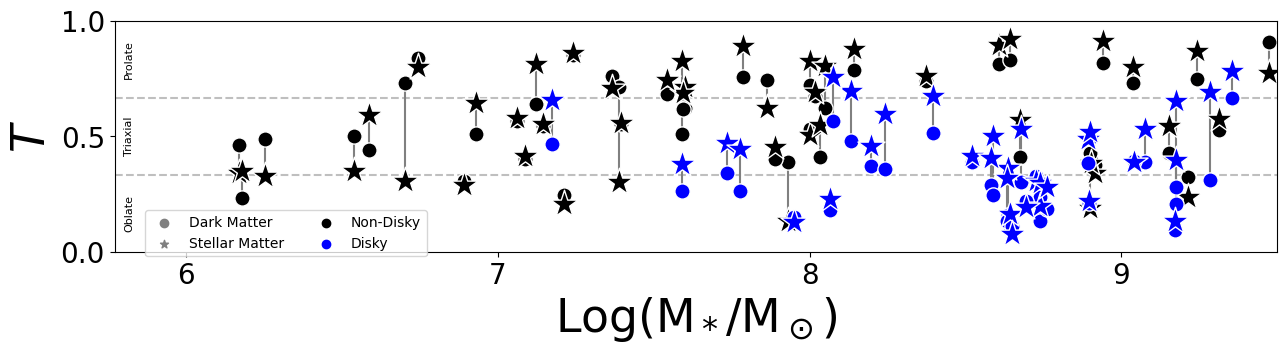

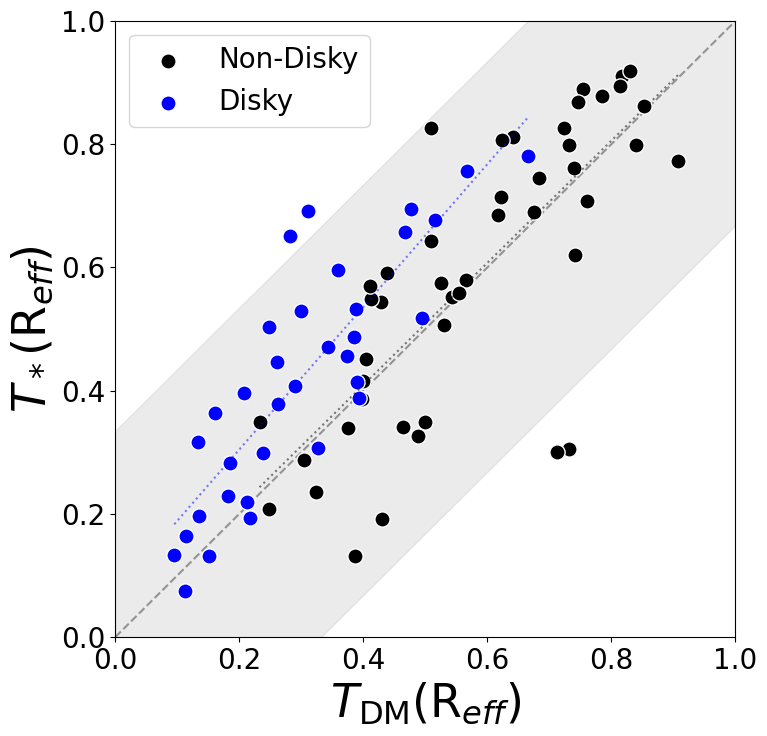

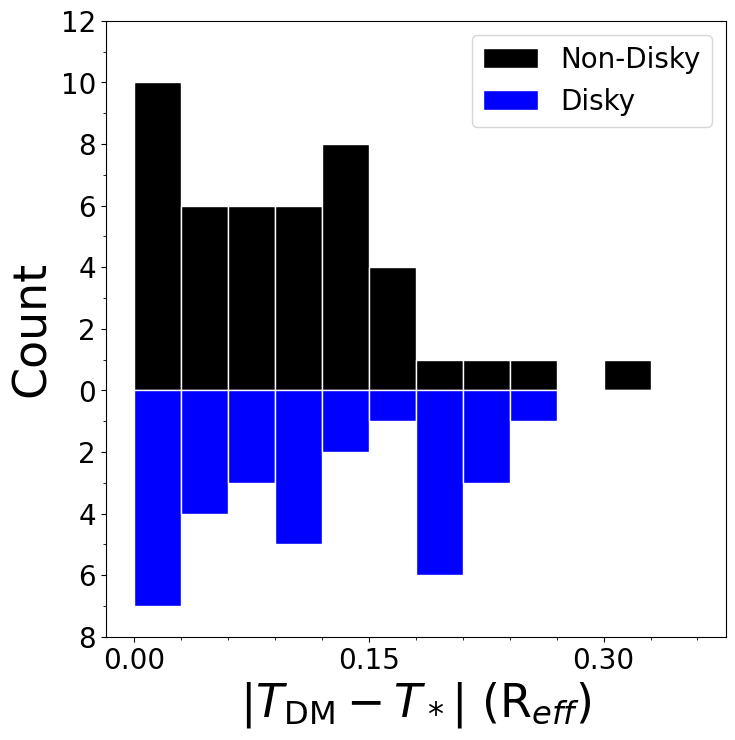

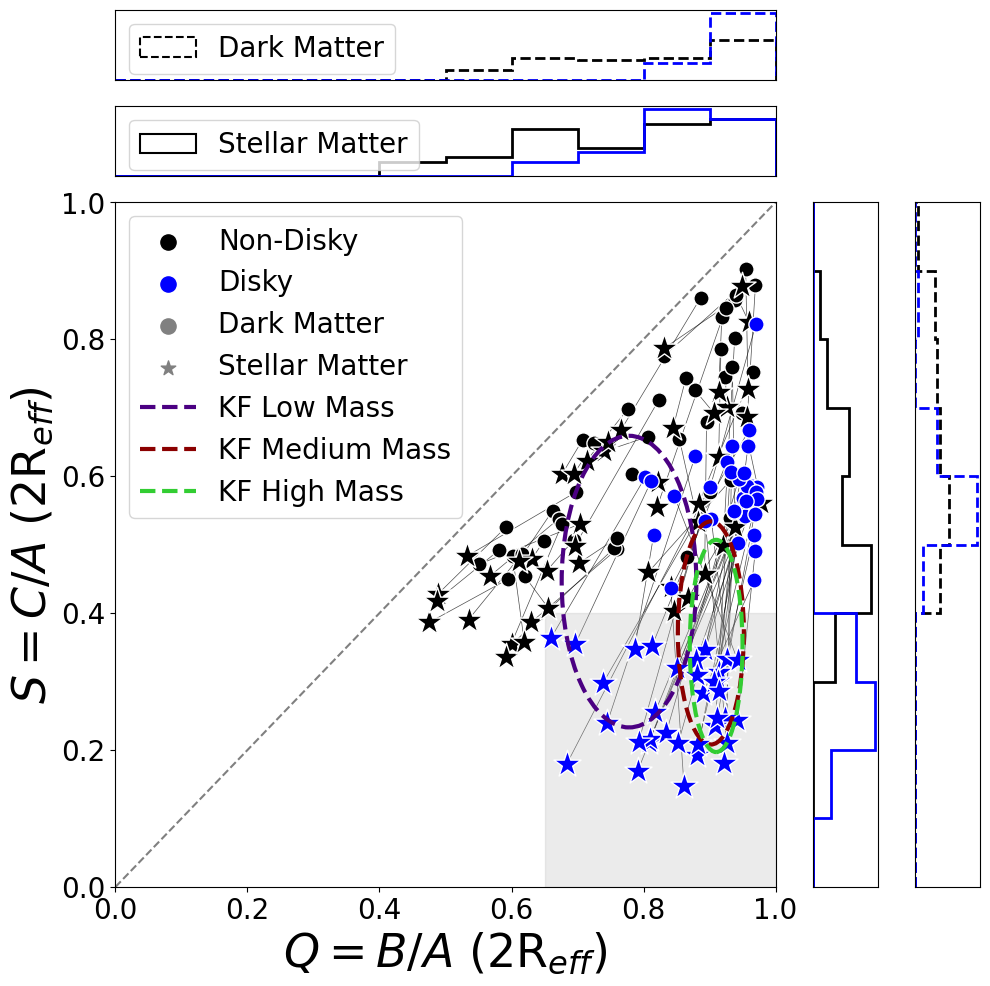

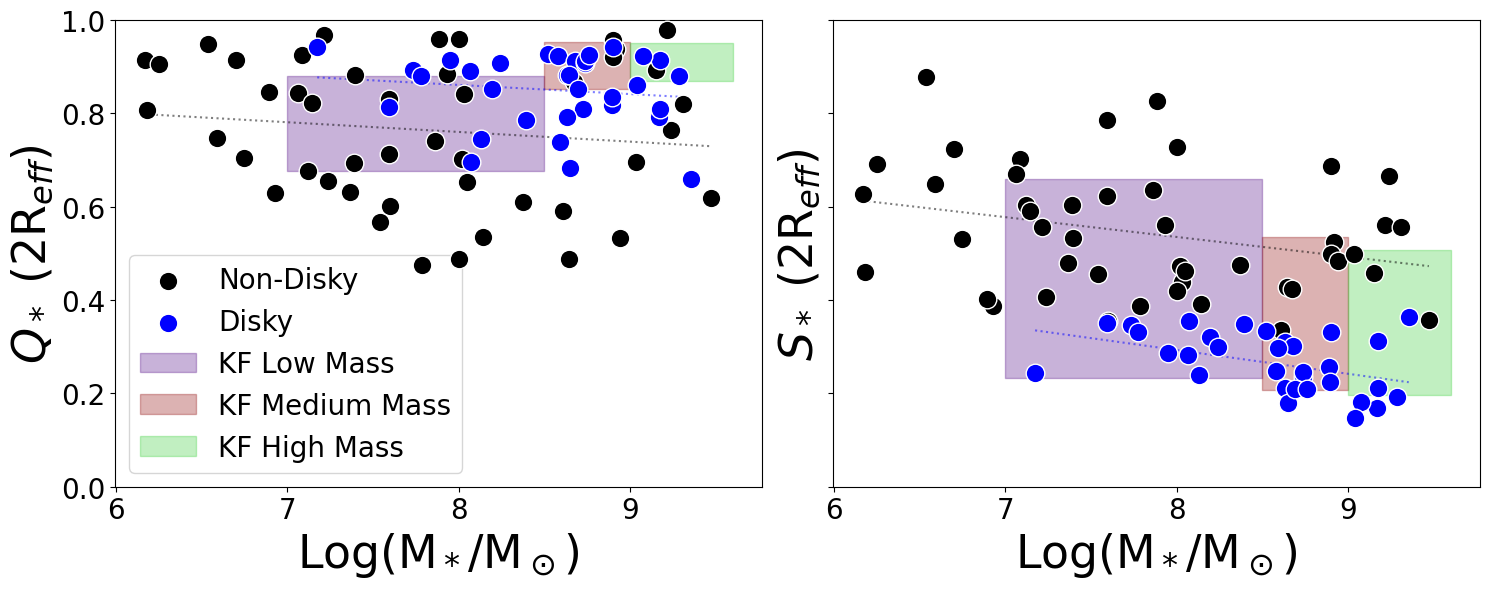

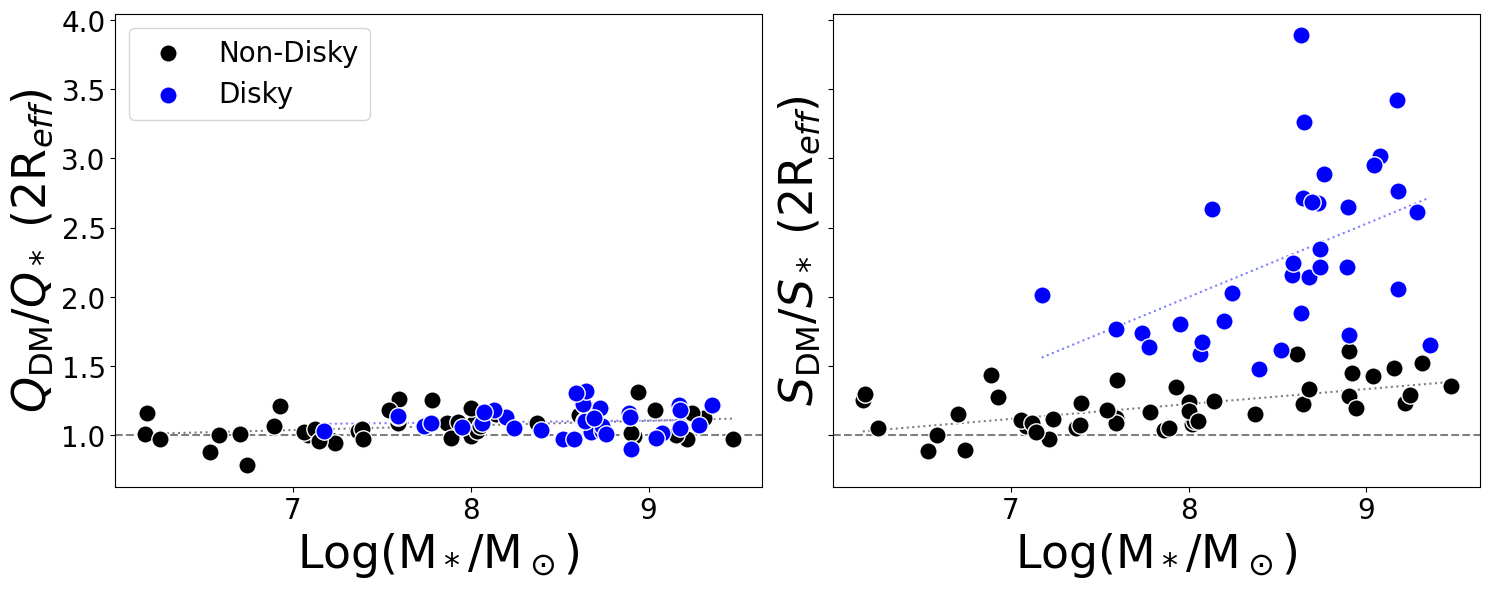

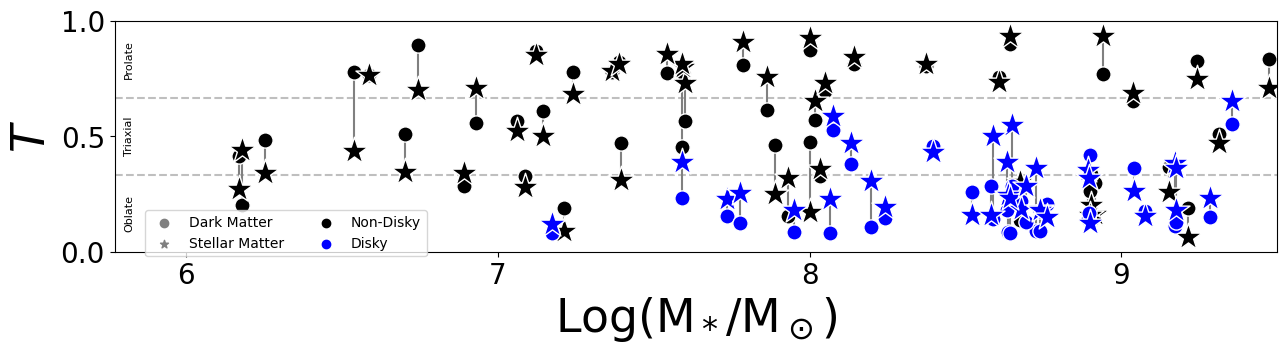

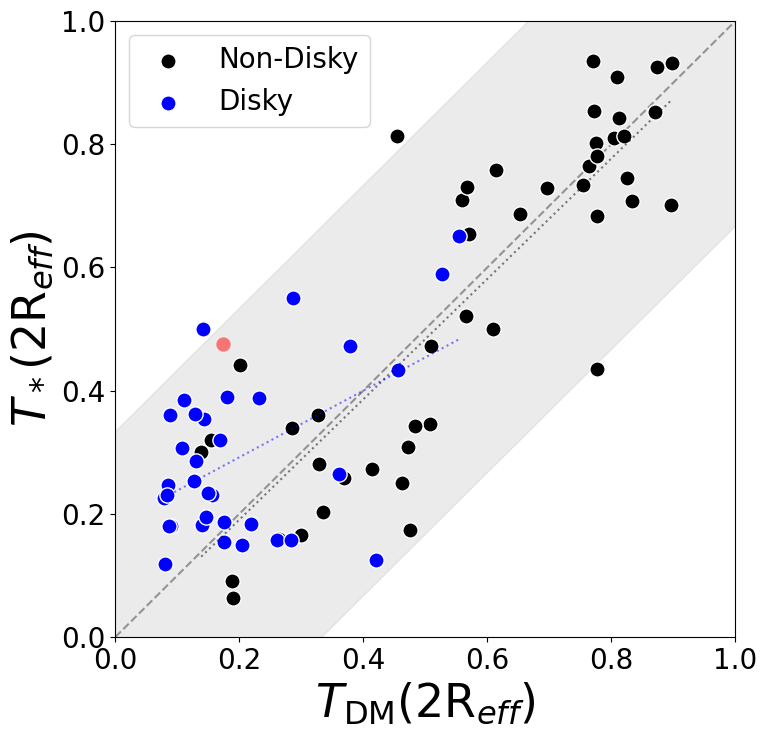

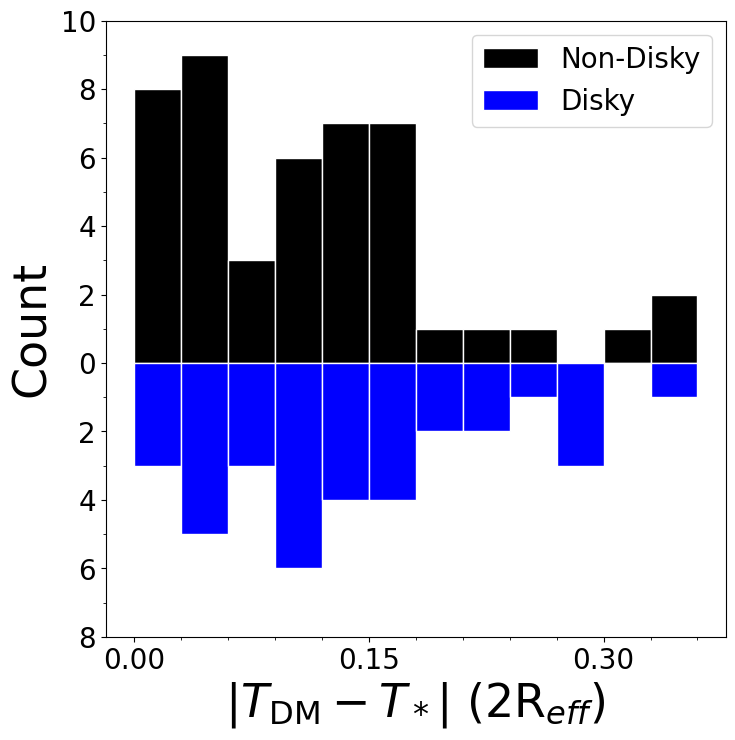

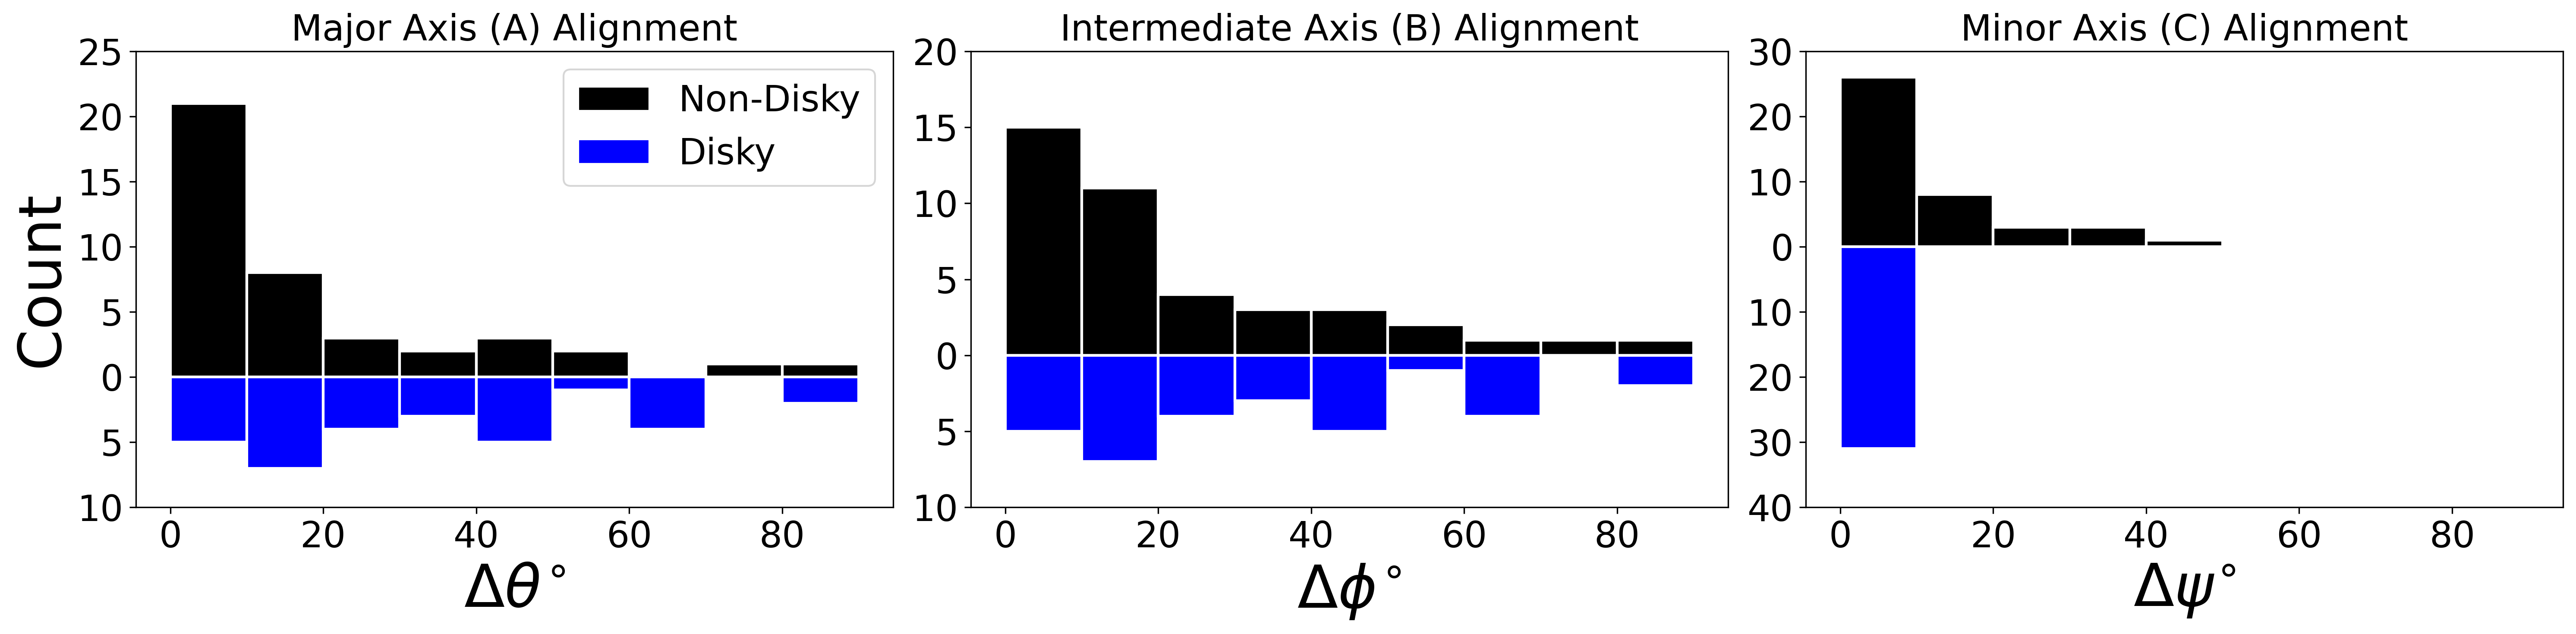

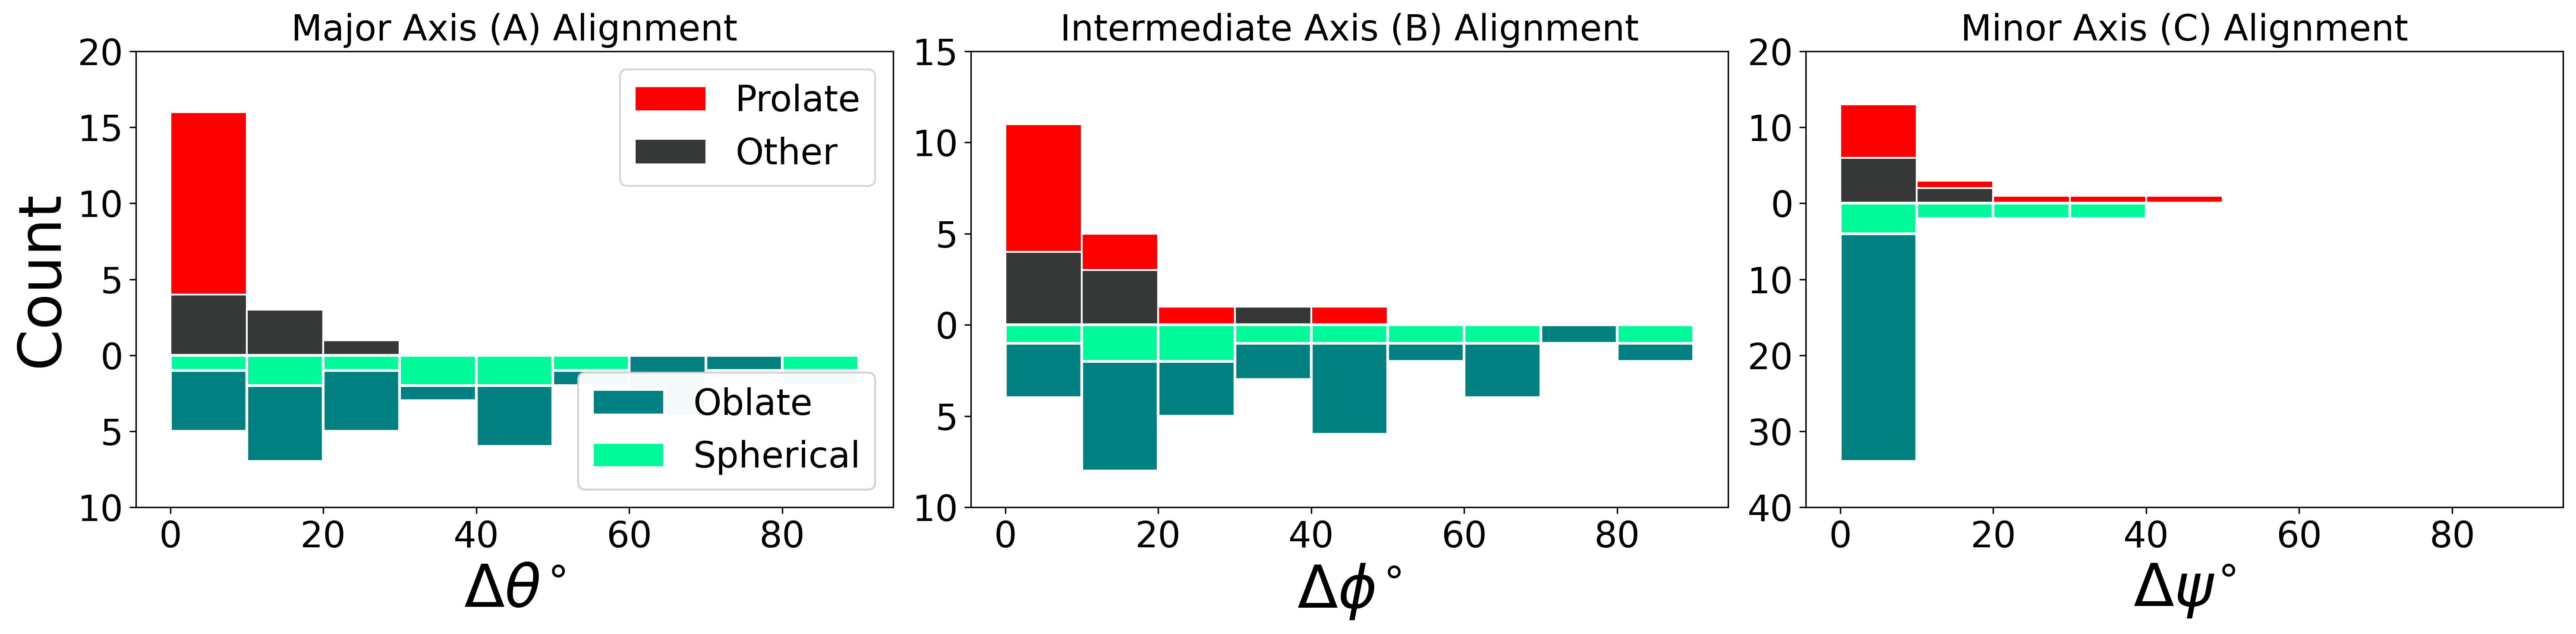

In [15]:

import numpy as np
from scipy import stats
import PlotClasses
#display classes in PlotClasses
#print(dir(PlotClasses))
#reload(PlotClasses)
importlib.reload(PlotClasses)
importlib.reload(sdt)

feedbacks = ['BWMDC', 'MerianCDM']
for reff_multi in [1,2]:
    #check if data has already been saved:
    if False:#os.path.exists(f'../../Data/BasicData/3DShapesData.{reff_multi}.pickle'):
        with open(f'../../Data/BasicData/3DShapesData.{reff_multi}.pickle', 'rb') as f:
            data_plot, masks, labels = pickle.load(f)
        B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, htype, reff, mvir, diffs_at_reff, hids = [data_plot[key] for key in ['B_s', 'C_s', 'T_s', 'B_d', 'C_d', 'T_d', 'masses', 'mb', 'htype', 'reff', 'mvir', 'diffs_at_reff', 'halo_id']]
        disks_mask = masks['disky']

    else:
        B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,mb_reff,mb_10rvir,htype,reff,mvir,feedback_type,sims,hids,mergers,rvir,diffs_at_reff, jz_jcirc_avgs,t_dyn = sdt.LoadSimData(feedbacks,return_sims=True,reff_multi=reff_multi)

        masks = {'non-disky': ~disks_mask, 'disky': disks_mask}
        data_plot = {
        'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
        'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir,'reff_multi':reff_multi,
        'diffs_at_reff': diffs_at_reff, 'halo_id': hids, 'Jz_Jcirc': jz_jcirc_avgs, 't_dyn': t_dyn,
        'sims': sims

        }
        labels = {'non-disky': 'Non-Disky', 'disky': 'Disky', 'B': 'Q', 'C': 'S'}

    colors = {'non-disky': 'k', 'disky': 'blue'}


    # Test the function
    results_all = perform_ks_tests(B_s, B_d, C_s, C_d)
    print("\nAll data:")
    print(f"B: statistic={results_all['B_statistic']:.2f}, p-value={results_all['B_pvalue']:.2e}")
    print(f"C: statistic={results_all['C_statistic']:.2f}, p-value={results_all['C_pvalue']:.2e}")

    # Test with masks
    for mask_name, mask in masks.items():
        results = perform_ks_tests(B_s, B_d, C_s, C_d, mask)
        print(f"\n{mask_name} galaxies:")
        print(f"B: statistic={results['B_statistic']:.2f}, p-value={results['B_pvalue']:.2e}")
        print(f"C: statistic={results['C_statistic']:.2f}, p-value={results['C_pvalue']:.2e}")



    #disk_mask = (C_s < .4) & (T_s < .666)
    

    #print(len(sims))
    

    #recreate disk_mask for galaxies where C_s < .4, and T_s < 0.6

    print(f'number of disk galaxies at reff_multi {reff_multi}: {sum(disks_mask)}')
    print(f'number of non-disk galaxies at reff_multi {reff_multi}: {sum(~disks_mask)}')


    #Usage example:
    #folder = '/home/bk639/OverLeaf/ShapePaper/'
    folder = '../../Figures/PaperFigures/'
    #create folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    #save data and masks to pickle file
    with open(f'../../Data/BasicData/3DShapesData.{reff_multi}.pickle', 'wb') as f:
        pickle.dump((data_plot, masks, labels), f)


    plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    plotter.plot_KF_data = True
    plotter.plot_regression = True
    plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder +  f'SvQ_disky.{reff_multi}.png')
    plotter.plot_Mstar_V_QvS(filename=folder + f'Mstar_V_QvS_disky.{reff_multi}.png')
    plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_disky.{reff_multi}.png')
    plotter.calculate_shape_diff()
    plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_disky.{reff_multi}.png')
    plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_disky.{reff_multi}.png')
    #plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d.{reff_multi}.png')
    plotter.plot_triaxiality_histograms(filename=folder + f'Triaxiality_histograms_disky.{reff_multi}.png')
    if reff_multi == 2:
        plotter.plot_angle_distributions(filename=folder + f'angle_distributions.{reff_multi}.png')


    #craete plot based on htype, either satellite or central
    central_mask = htype == 'o'
    satellite_mask = htype == 'v'

    #create masks for galaxies that are both satellite and disky
    disk_satellite_mask = disks_mask & satellite_mask

    masks = {'central': central_mask, 'satellite': satellite_mask, 'disky satellite': disk_satellite_mask}
    labels = {'central': 'Central', 'satellite': 'Satellite', 'disky satellite': 'Disky Satellite', 'B': 'Q', 'C': 'S'}

    print(f'number of central galaxies: {sum(central_mask)}')
    print(f'number of satellite galaxies: {sum(satellite_mask)}')
    print(f'number of disk satellite galaxies: {sum(disk_satellite_mask)}')

    colors = {'central': 'k', 'satellite': 'green', 'disky satellite': 'lightseagreen'}
    plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    #plotter.plot_KF_data = False
    # plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder + f'SvQ_central_satellite.{reff_multi}.png')
    # plotter.calculate_shape_diff()
    # plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_central_satellite.{reff_multi}.png')
    # plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_central_satellite.{reff_multi}.png')
    #plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_central_satellite.{reff_multi}.png')
    # plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d_central_satellite.{reff_multi}.png')
    # plotter.plot_Mstar_V_QvS(filename=folder + f'Mstar_V_QvS_central_satellite.{reff_multi}.png')
    # if reff_multi == 2:
    #     plotter.plot_angle_distributions(filename=folder + f'angle_distributions_central_satellite.{reff_multi}.png')









In [16]:
#load 3DShapesData{i}.pickle files and save in standard machine readable format
with open(f'../../Data/BasicData/3DShapesData.1.pickle', 'rb') as f:
    data1, masks1, labels1 = pickle.load(f)
with open(f'../../Data/BasicData/3DShapesData.2.pickle', 'rb') as f:
    data2, masks2, labels2 = pickle.load(f)


In [21]:
data2.keys()

dict_keys(['B_s', 'C_s', 'T_s', 'B_d', 'C_d', 'T_d', 'masses', 'mb', 'htype', 'reff', 'mvir', 'reff_multi', 'diffs_at_reff', 'halo_id', 'Jz_Jcirc', 't_dyn', 'sims'])

In [1]:
import pickle
import numpy as np
import os

def convert_pickle_to_mrt(pickle_file, output_file):
    """
    Convert a pickle file with simulation data to a Machine Readable Table (MRT)
    following AAS style guide.

    Parameters:
    -----------
    pickle_file : str
        Path to the pickle file
    output_file : str
        Path to the output text file
    """
    # Load the pickle file
    with open(pickle_file, 'rb') as f:
        data_plot, masks, labels = pickle.load(f)

    # Extract the data - handle missing keys safely
    B_s = data_plot.get('B_s', [])
    C_s = data_plot.get('C_s', [])
    T_s = data_plot.get('T_s', [])
    B_d = data_plot.get('B_d', [])
    C_d = data_plot.get('C_d', [])
    T_d = data_plot.get('T_d', [])
    masses = data_plot.get('masses', [])
    mvir = data_plot.get('mvir', [])
    reff = data_plot.get('reff', [])
    reff_multi = data_plot.get('reff_multi', 1)
    hids = data_plot.get('halo_id', [])
    htype = data_plot.get('htype', [])
    diffs_at_reff = data_plot.get('diffs_at_reff', [])

    # Additional data mentioned by the user
    sims = data_plot.get('sims', [])
    jz_jcirc_avgs = data_plot.get('Jz_Jcirc', [])
    rvir = data_plot.get('rvir', [])
    t_dyn = data_plot.get('t_dyn', [])

    # Determine number of galaxies
    n_galaxies = len(B_s)

    # Create the header
    header = [
        "# Title: Galaxy Shape Parameters and Properties",
        "# Authors: Blake Keith",
        "# Table: Galaxy Simulation Data",
        "#",
        "# Column information:",
        "# 1. SimName (char): Simulation name",
        "# 2. HaloID (int): Halo identification number",
        "# 3. HaloType (char): Halo type ('o' for central, 'v' for satellite)",
        "# 4. B_s (float): Axis ratio B/A for stellar matter [unitless]",
        "# 5. C_s (float): Axis ratio C/A for stellar matter [unitless]",
        "# 6. T_s (float): Triaxiality parameter for stellar matter [unitless]",
        "# 7. B_d (float): Axis ratio B/A for dark matter [unitless]",
        "# 8. C_d (float): Axis ratio C/A for dark matter [unitless]",
        "# 9. T_d (float): Triaxiality parameter for dark matter [unitless]",
        "# 10. StellarMass (float): Log10 of stellar mass [log(Msun)]",
        "# 11. HaloMass (float): Virial mass of the halo [Msun]",
        "# 12. Reff (float): Effective radius [kpc]",
        "# 13. ReffMulti (int): The multiplier at which measurements are taken"
    ]

    # Add optional columns if data is available
    col_num = 14

    if len(jz_jcirc_avgs) == n_galaxies:
        header.append(f"# {col_num}. Jz_Jcirc (float): Ratio of z-component of angular momentum to circular angular momentum, averaged over all particles in the halo [unitless]")
        col_num += 1

    if len(rvir) == n_galaxies:
        header.append(f"# {col_num}. Rvir (float): Virial radius [kpc]")
        col_num += 1

    if len(t_dyn) == n_galaxies:
        header.append(f"# {col_num}. TDyn (float): Dynamical time at virial radius [Gyr]")
        col_num += 1

    # If diffs_at_reff exists and reff_multi == 2, add columns for angle differences
    has_diff_data = len(diffs_at_reff) > 0 and reff_multi == 2
    if has_diff_data:
        header.extend([
            f"# {col_num}. AbsAngle (float): Absolute angle between dark matter and stellar matter [degrees]",
            f"# {col_num+1}. AxisA_Angle (float): Angle difference for axis A [degrees]",
            f"# {col_num+2}. AxisB_Angle (float): Angle difference for axis B [degrees]",
            f"# {col_num+3}. AxisC_Angle (float): Angle difference for axis C [degrees]"
        ])

    # Join header lines
    header = "\n".join(header)

    # Create a mapping of halo IDs to diff records for quick lookup
    diff_map = {}
    if has_diff_data:
        for diff in diffs_at_reff:
            if 'halo_id' in diff and 'simulation' in diff:
                key = (diff['simulation'], diff['halo_id'])
                diff_map[key] = diff

    # Create the data rows
    rows = []

    for i in range(n_galaxies):
        row = []

        # Add sim name if available
        sim_name = "Unknown"
        if len(sims) == n_galaxies:
            sim_name = sims[i]
        row.append(f"{sim_name}")

        # Add halo ID if available
        halo_id = -1
        if len(hids) == n_galaxies:
            halo_id = hids[i]
        row.append(f"{halo_id}")

        # Add halo type if available
        halo_type = "u"
        if len(htype) == n_galaxies:
            halo_type = htype[i]
        row.append(f"{halo_type}")

        # Add shape parameters
        row.append(f"{B_s[i]:.6f}")
        row.append(f"{C_s[i]:.6f}")
        row.append(f"{T_s[i]:.6f}")
        row.append(f"{B_d[i]:.6f}")
        row.append(f"{C_d[i]:.6f}")
        row.append(f"{T_d[i]:.6f}")

        # Add masses and radii
        row.append(f"{masses[i]:.6f}")
        row.append(f"{mvir[i]:.6e}")  # Scientific notation for large halo masses
        row.append(f"{reff[i]:.6f}")
        row.append(f"{reff_multi}")

        # Add optional data if available
        if len(jz_jcirc_avgs) == n_galaxies:
            row.append(f"{jz_jcirc_avgs[i]:.6f}")

        if len(rvir) == n_galaxies:
            row.append(f"{rvir[i]:.6f}")

        if len(t_dyn) == n_galaxies:
            row.append(f"{t_dyn[i]:.6f}")

        # Add angle differences if available
        if has_diff_data:
            # Try to find the corresponding diff record
            diff_record = None
            if len(sims) == n_galaxies and len(hids) == n_galaxies:
                key = (sims[i], hids[i])
                diff_record = diff_map.get(key)

            if diff_record:
                row.append(f"{diff_record.get('absolute_angle', np.nan):.6f}")
                row.append(f"{diff_record.get('axis_a_angle', np.nan):.6f}")
                row.append(f"{diff_record.get('axis_b_angle', np.nan):.6f}")
                row.append(f"{diff_record.get('axis_c_angle', np.nan):.6f}")
            else:
                row.extend(["NaN", "NaN", "NaN", "NaN"])

        rows.append("\t".join(row))

    # Combine header and rows
    content = header + "\n" + "\n".join(rows)

    # Write to file
    with open(output_file, 'w') as f:
        f.write(content)

    return n_galaxies

# Example usage
for reff_multi in [1, 2]:
    pickle_file = f'../../Data/BasicData/3DShapesData.{reff_multi}.pickle'
    output_file = f'../../Data/galaxy_shapes_reff{reff_multi}.txt'

    if os.path.exists(pickle_file):
        try:
            n_rows = convert_pickle_to_mrt(pickle_file, output_file)
            print(f"Converted {n_rows} galaxies to {output_file}")
        except Exception as e:
            print(f"Error converting {pickle_file}: {e}")
    else:
        print(f"Pickle file {pickle_file} not found")

Converted 80 galaxies to ../../Data/galaxy_shapes_reff1.txt
Converted 80 galaxies to ../../Data/galaxy_shapes_reff2.txt


In [83]:
print(data1['diffs_at_reff'])

[{'simulation': 'cptmarvel', 'halo_id': 1, 'radius': np.float64(2.374519552267851), 'absolute_angle': np.float64(2.8631241684900886), 'axis_a_angle': np.float64(54.367331357634654), 'axis_b_angle': np.float64(54.396361764205295), 'axis_c_angle': np.float64(4.370937180135255)}
 {'simulation': 'cptmarvel', 'halo_id': 2, 'radius': np.float64(3.5330088714603565), 'absolute_angle': np.float64(nan), 'axis_a_angle': np.float64(nan), 'axis_b_angle': np.float64(nan), 'axis_c_angle': np.float64(nan)}
 {'simulation': 'cptmarvel', 'halo_id': 3, 'radius': np.float64(1.6217954088108268), 'absolute_angle': np.float64(nan), 'axis_a_angle': np.float64(nan), 'axis_b_angle': np.float64(nan), 'axis_c_angle': np.float64(nan)}
 {'simulation': 'cptmarvel', 'halo_id': 5, 'radius': np.float64(1.4244869006016956), 'absolute_angle': np.float64(2.027301606485009), 'axis_a_angle': np.float64(1.8958102158307168), 'axis_b_angle': np.float64(0.7521428894930667), 'axis_c_angle': np.float64(2.0149404931680226)}
 {'simu

In [23]:
import pandas as pd
import numpy as np
import os

def load_mrt(file_path):
    """
    Load a Machine Readable Table in AAS format and return a pandas DataFrame.

    Parameters:
    -----------
    file_path : str
        Path to the MRT file

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the data from the MRT
    """
    # Read the file
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Extract header lines (those starting with #)
    header_lines = [line.strip() for line in lines if line.startswith('#')]

    # Extract column names from header
    column_names = []
    for line in header_lines:
        if 'Column information' in line:
            continue
        if ':' in line and '#' in line:
            parts = line.split(':')
            if len(parts) >= 2:
                # Extract column number and name
                col_info = parts[0].strip('# ').split('.')[0]
                try:
                    col_num = int(col_info)
                    # Get the column name (the part after the first colon and before the next parenthesis)
                    col_name = parts[1].strip().split('(')[0].strip()
                    column_names.append(col_name)
                except ValueError:
                    # Not a numbered column line
                    pass

    # Create DataFrame
    df = pd.read_csv(file_path, comment='#', sep='\t', header=None, names=column_names)

    # Convert numeric columns to appropriate types
    numeric_columns = ['B_s', 'C_s', 'T_s', 'B_d', 'C_d', 'T_d',
                       'StellarMass', 'HaloMass', 'Reff', 'ReffMulti']

    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Convert additional optional numeric columns if they exist
    optional_numeric = ['Jz_Jcirc', 'Rvir', 'TDyn',
                         'AbsAngle', 'AxisA_Angle', 'AxisB_Angle', 'AxisC_Angle']

    for col in optional_numeric:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# Example usage
for reff_multi in [1, 2]:
    file_path = f'galaxy_shapes_reff{reff_multi}.txt'
    if os.path.exists(file_path):
        try:
            df = load_mrt(file_path)
            print(f"Loaded {len(df)} galaxies from {file_path}")
            print(f"Columns: {df.columns.tolist()}")
            print(df.head())
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    else:
        print(f"MRT file {file_path} not found")

Loaded 80 galaxies from galaxy_shapes_reff1.txt
Columns: ['Simulation name', 'Halo identification number', 'Halo type', 'Axis ratio B/A for stellar matter [unitless]', 'Axis ratio C/A for stellar matter [unitless]', 'Triaxiality parameter for stellar matter [unitless]', 'Axis ratio B/A for dark matter [unitless]', 'Axis ratio C/A for dark matter [unitless]', 'Triaxiality parameter for dark matter [unitless]', 'Log10 of stellar mass [log', 'Virial mass of the halo [Msun]', 'Effective radius [kpc]', 'The multiplier at which measurements are taken', 'Dynamical time at virial radius [Gyr]']
  Simulation name  Halo identification number Halo type  \
0       cptmarvel                           1         o   
1       cptmarvel                           2         o   
2       cptmarvel                           3         o   
3       cptmarvel                           5         o   
4       cptmarvel                           6         o   

   Axis ratio B/A for stellar matter [unitless]  \


In [25]:
df

,Simulation name,Halo identification number,Halo type,Axis ratio B/A for stellar matter [unitless],Axis ratio C/A for stellar matter [unitless],Triaxiality parameter for stellar matter [unitless],Axis ratio B/A for dark matter [unitless],Axis ratio C/A for dark matter [unitless],Triaxiality parameter for dark matter [unitless],Log10 of stellar mass [log,Virial mass of the halo [Msun],Effective radius [kpc],The multiplier at which measurements are taken,Dynamical time at virial radius [Gyr],Absolute angle between dark matter and stellar matter [degrees],Angle difference for axis A [degrees],Angle difference for axis B [degrees],Angle difference for axis C [degrees]
0,cptmarvel,1,o,0.893277,0.346816,0.229683,0.952095,0.604034,0.147236,7.735159,1.517224e+10,2.381722,2,0.157302,2.863124,54.367331,54.396362,4.370937
1,cptmarvel,2,o,0.955256,0.244983,0.093072,0.969785,0.490265,0.078348,7.173798,9.387201e+09,3.575341,2,0.367815,NaN,NaN,NaN,NaN
2,cptmarvel,3,o,0.629203,0.387901,0.711100,0.766746,0.496447,0.546887,6.929599,8.162479e+09,1.598883,2,0.117960,NaN,NaN,NaN,NaN
3,cptmarvel,5,o,0.918254,0.694541,0.302948,0.924446,0.734013,0.315245,7.087105,7.294522e+09,1.451125,2,0.107890,2.027302,1.895810,0.752143,2.014940
4,cptmarvel,6,o,0.843899,0.670796,0.523304,0.863759,0.742578,0.566055,7.059747,6.183828e+09,1.099077,2,0.077239,17.016912,11.850796,14.231006,15.325764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,r852,1,o,0.652920,0.461816,0.729219,0.690125,0.503366,0.701461,8.050318,3.118053e+10,1.617017,2,0.061383,8.846309,5.912921,8.840618,6.581648
76,r886,1,o,0.729359,0.295845,0.512929,0.955320,0.659293,0.154534,8.589570,4.023072e+10,3.572290,2,0.177444,23.970442,23.217002,23.377313,7.870489
77,r916,1,o,0.698043,0.355360,0.586843,0.801657,0.580059,0.538551,8.074261,2.648652e+10,2.108925,2,0.099197,3.607317,4.529405,2.738340,3.607413
78,r918,1,o,0.868341,0.422900,0.299559,0.933935,0.543523,0.181335,8.674523,5.655482e+10,5.069726,2,0.253025,7.007088,6.562539,6.982971,2.521077


In [82]:
#print the first entry of each key in data2
for key in data2:
    if key == 'reff_multi':
        print(key, data2[key])
    else:
        try:
            print(key, data1[key][0])
        except TypeError:
            print(key)


B_s 0.7656441272377822
C_s 0.3512704444606969
T_s 0.47203375175857315
B_d 0.8682655023611767
C_d 0.5352259983862956
T_d 0.3449244426601635
masses 7.735158720631543
mb 0.025451113017312475
htype o
reff 1.1908610721781792
mvir 15172236026.341885
reff_multi 2
diffs_at_reff {'simulation': 'cptmarvel', 'halo_id': 1, 'radius': np.float64(2.374519552267851), 'absolute_angle': np.float64(2.8631241684900886), 'axis_a_angle': np.float64(54.367331357634654), 'axis_b_angle': np.float64(54.396361764205295), 'axis_c_angle': np.float64(4.370937180135255)}
halo_id 1


Non-Disky galaxies: B_D/B_* mean: 1.12, std: 0.14
Disky galaxies: B_D/B_* mean: 1.17, std: 0.14
Non-Disky galaxies: C_D/C_* mean: 1.29, std: 0.25
Disky galaxies: C_D/C_* mean: 2.05, std: 0.53
Non-Disky galaxies: T_D/T_* mean: 1.05, std: 0.42
Disky galaxies: T_D/T_* mean: 0.82, std: 0.38


Non-Disky galaxies: B_D/B_* mean: 1.06, std: 0.10
Disky galaxies: B_D/B_* mean: 1.10, std: 0.09
Non-Disky galaxies: C_D/C_* mean: 1.21, std: 0.20
Disky galaxies: C_D/C_* mean: 2.13, std: 0.62
Non-Disky galaxies: T_D/T_* mean: 1.16, std: 0.47
Disky galaxies: T_D/T_* mean: 0.83, std: 0.60




In [ ]:
# sort sims,hids, by mass
masses = 10**masses
sorted_indices = np.argsort(masses)
masses = masses[sorted_indices]
sims = sims[sorted_indices]
hids = hids[sorted_indices]

In [ ]:
for i in range(len(sims)):
    print(f'sims: {sims[i]}, hids: {hids[i]}, mass: {masses[i]:.2e}')

In [ ]:
#how many sattelite galaxies are also non-disky
n_same = 0
n_diff = 0
for i in range(len(sims)):
    if satellite_mask[i] and ~disk_mask[i]:
        print(f'sims: {sims[i]}, hids: {hids[i]}')
        n_same += 1
    elif satellite_mask[i] and disk_mask[i]:
        n_diff += 1
print(f'number both sat, and disky: {n_same}')
print(f'number sat, not disky: {n_diff}')


['../PickleFiles/SimulationInfo.BWMDC.pickle', '../PickleFiles/SimulationInfo.SBMarvel.pickle']
Error loading diff_at_Reff for sim storm halo 1
Error loading jz_jcirc_avg for sim storm halo 1
Error loading diff_at_Reff for sim storm halo 2
Error loading jz_jcirc_avg for sim storm halo 2
Error loading diff_at_Reff for sim storm halo 3
Error loading jz_jcirc_avg for sim storm halo 3
Error loading diff_at_Reff for sim storm halo 4
Error loading jz_jcirc_avg for sim storm halo 4
Error loading diff_at_Reff for sim storm halo 5
Error loading jz_jcirc_avg for sim storm halo 5
Error loading diff_at_Reff for sim storm halo 6
Error loading jz_jcirc_avg for sim storm halo 6
Error loading diff_at_Reff for sim storm halo 7
Error loading jz_jcirc_avg for sim storm halo 7
Error loading diff_at_Reff for sim storm halo 8
Error loading jz_jcirc_avg for sim storm halo 8
Error loading diff_at_Reff for sim storm halo 14
Error loading jz_jcirc_avg for sim storm halo 14
['storm' 'storm' 'storm' 'storm' 'stor

/home/bk639/miniconda3/envs/pynbody_beta/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


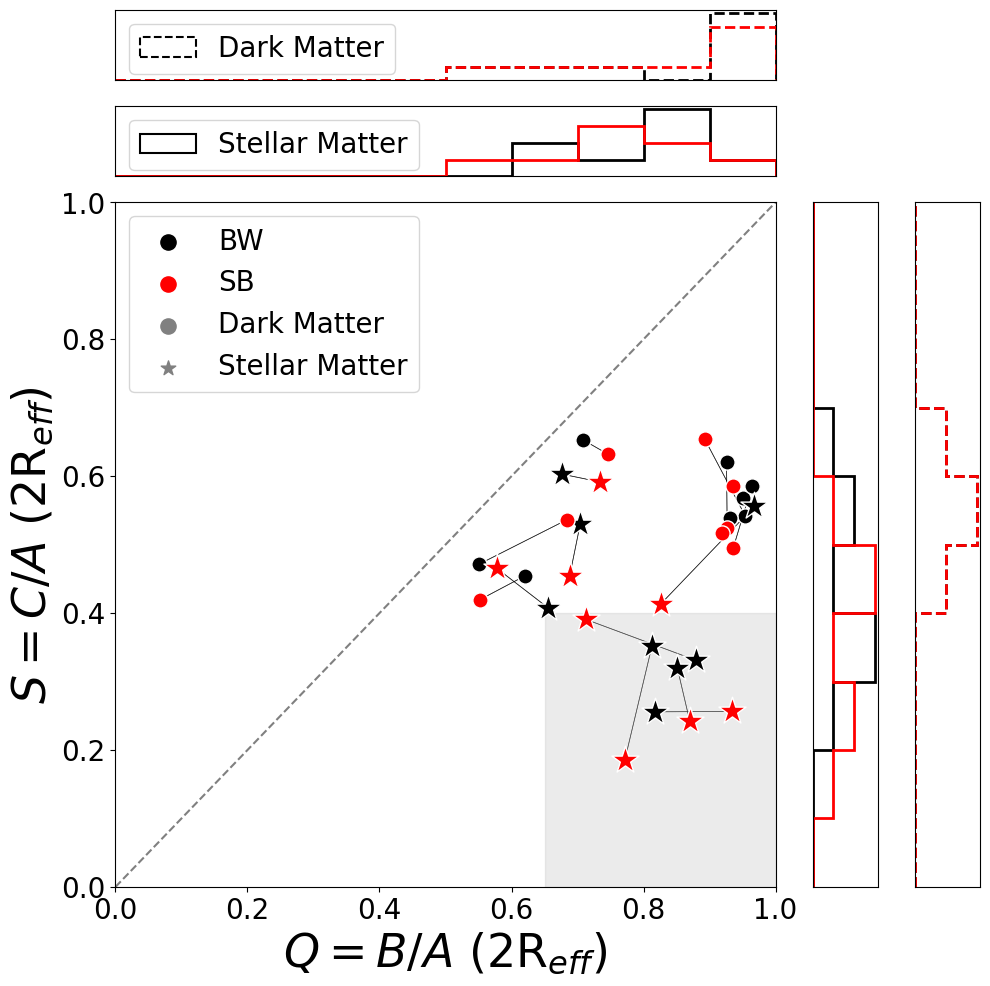

In [29]:
#compare differences between superbubble and BW feedback in storm

import pandas as pd
import numpy as np
#reload sdt
import importlib
importlib.reload(sdt)
importlib.reload(PlotClasses)

feedbacks = ['BWMDC', 'SBMarvel']


def analyze_feedback_differences(B_s, C_s, T_s, B_d, C_d, T_d, masses, reff, mvir, rvir,
                               hids, feedback_type, feedbacks):
    # Create DataFrame for per-halo differences
    halo_diffs = []

    for halo in np.unique(hids):
        mask = hids == halo
        if np.sum(mask) == 2:  # Only compare when we have both feedback types
            diff_dict = {
                'halo_id': halo,
                'mass': masses[mask],  # Taking first value since they're same halo
                'reff': reff[mask],
                'mvir': mvir[mask],
                'rvir': rvir[mask],
                'B_s_diff': (B_s[mask][0] - B_s[mask][1]),
                'C_s_diff': (C_s[mask][0] - C_s[mask][1]),
                'T_s_diff': (T_s[mask][0] - T_s[mask][1]),
                'B_d_diff': (B_d[mask][0] - B_d[mask][1]),
                'C_d_diff': (C_d[mask][0] - C_d[mask][1]),
                'T_d_diff': (T_d[mask][0] - T_d[mask][1])
            }
            halo_diffs.append(diff_dict)

    # Create DataFrame for feedback type statistics
    feedback_stats = []

    for feedback in feedbacks:
        mask = feedback_type == feedback
        stats_dict = {
            'feedback_type': feedback,
            'B_s_mean': np.mean(B_s[mask]),
            'B_s_std': np.std(B_s[mask]),
            'C_s_mean': np.mean(C_s[mask]),
            'C_s_std': np.std(C_s[mask]),
            'T_s_mean': np.mean(T_s[mask]),
            'T_s_std': np.std(T_s[mask]),
            'B_d_mean': np.mean(B_d[mask]),
            'B_d_std': np.std(B_d[mask]),
            'C_d_mean': np.mean(C_d[mask]),
            'C_d_std': np.std(C_d[mask]),
            'T_d_mean': np.mean(T_d[mask]),
            'T_d_std': np.std(T_d[mask])
        }
        feedback_stats.append(stats_dict)

    # KS test to see if distriubutions are different between feedback types
    ks_B = stats.ks_2samp(B_s[feedback_type == feedbacks[0]], B_s[feedback_type == feedbacks[1]])
    ks_C = stats.ks_2samp(C_s[feedback_type == feedbacks[0]], C_s[feedback_type == feedbacks[1]])
    ks_T = stats.ks_2samp(T_s[feedback_type == feedbacks[0]], T_s[feedback_type == feedbacks[1]])
    ks_B_d = stats.ks_2samp(B_d[feedback_type == feedbacks[0]], B_d[feedback_type == feedbacks[1]])
    ks_C_d = stats.ks_2samp(C_d[feedback_type == feedbacks[0]], C_d[feedback_type == feedbacks[1]])
    ks_T_d = stats.ks_2samp(T_d[feedback_type == feedbacks[0]], T_d[feedback_type == feedbacks[1]])

    ks_stats = {
        #'B_s_statistic': ks_B.statistic,
        'B_s_pvalue': ks_B.pvalue,
        #'C_s_statistic': ks_C.statistic,
        'C_s_pvalue': ks_C.pvalue,
        #'T_s_statistic': ks_T.statistic,
        #'T_s_pvalue': ks_T.pvalue,
        #'B_d_statistic': ks_B_d.statistic,
        'B_d_pvalue': ks_B_d.pvalue,
        #'C_d_statistic': ks_C_d.statistic,
        'C_d_pvalue': ks_C_d.pvalue,
        #'T_d_statistic': ks_T_d.statistic,
        #'T_d_pvalue': ks_T_d.pvalue
    }
    print(ks_stats)


    # Convert to DataFrames
    halo_diff_df = pd.DataFrame(halo_diffs)
    feedback_stats_df = pd.DataFrame(feedback_stats)

    return halo_diff_df, feedback_stats_df

# Modified main code
for reff_multi in [2]:
    B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, mb_reff, mb_10rvir, htype, reff, mvir, \
    feedback_type, sims, hids, mergers, rvir, diffs_at_reff, jz_jcirc_avgs, t_dyn = \
    sdt.LoadSimData(feedbacks, return_sims=True, reff_multi=reff_multi, fixed_r=False)

    # Apply initial mask
    mask = ((sims == 'storm') & (hids != 31) & (hids != 14) & (masses > 5) & (masses < 10))

    # Apply mask to all variables
    variables = [B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, mb_reff, mb_10rvir, htype,
                reff, mvir, feedback_type, sims, hids, rvir, diffs_at_reff,
                jz_jcirc_avgs, t_dyn]

    B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, mb_reff, mb_10rvir, htype, reff, mvir, \
    feedback_type, sims, hids, rvir, diffs_at_reff, jz_jcirc_avgs, t_dyn = \
    [var[mask] for var in variables]

    print(sims,hids,feedback_type)

    #swap hid labels 6 and 8 for feedback_type == 'SBMarvel'
    mask = feedback_type == 'SBMarvel'
    hids[mask] = np.where(hids[mask] == 6, 8, np.where(hids[mask] == 8, 6, hids[mask]))

    #replace reff in SBMarvel with reff in BWMDC
    # mask = feedback_type == 'SBMarvel'
    # reff[mask] = reff[feedback_type == 'BWMDC']

    # Generate analysis DataFrames
    halo_differences, feedback_statistics = analyze_feedback_differences(
        B_s, C_s, T_s, B_d, C_d, T_d, masses, reff, mvir, rvir, hids, feedback_type, feedbacks
    )

        #Usage example:
    folder = '../../Figures/PaperFigures/'
    #folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
    #create folder
    if not os.path.exists(folder):
        os.makedirs(folder)
    superbubble_mask = feedback_type == 'SBMarvel'
    data_plot = {
        'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
        'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir,'reff_multi':reff_multi,
        'sims': sims, 'hids': hids, 'feedback_type': feedback_type
    }
    masks = {'BW': ~superbubble_mask, 'SB': superbubble_mask}
    labels = {'BW': 'BW', 'SB': 'SB', 'B': 'Q', 'C': 'S'}
    colors = {'BW': 'k', 'SB': 'red'}

    plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    plotter.plot_KF_data = False
    plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder +  f'SvQ_SB_BW.{reff_multi}.png',link_sims=True)
    #plotter.calculate_shape_diff()
    #plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_disky.{reff_multi}.png')
    #plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_disky.{reff_multi}.png')
    #plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_disky.{reff_multi}.png')
    #plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d.{reff_multi}.png')


Processing BWMDC...
Data summary for BWMDC:
             hid   jz_jcirc     j_crit
count  51.000000  39.000000  51.000000
mean    9.725490   0.122379   0.376930
std    11.301466   0.550518   0.302280
min     1.000000  -0.034667   0.010837
25%     3.000000   0.000086   0.088332
50%     7.000000   0.006375   0.230535
75%    10.500000   0.042518   0.700000
max    65.000000   3.445466   0.700000
Processing MerianCDM...
Data summary for MerianCDM:
             hid   jz_jcirc     j_crit
count  38.000000  35.000000  38.000000
mean    1.105263   0.163284   0.288476
std     0.388307   0.150624   0.172497
min     1.000000  -0.003651   0.060109
25%     1.000000   0.016402   0.169169
50%     1.000000   0.121176   0.242099
75%     1.000000   0.289335   0.378116
max     3.000000   0.515400   0.700000
Number of data points with jz_jcirc < 10^-2.5
22


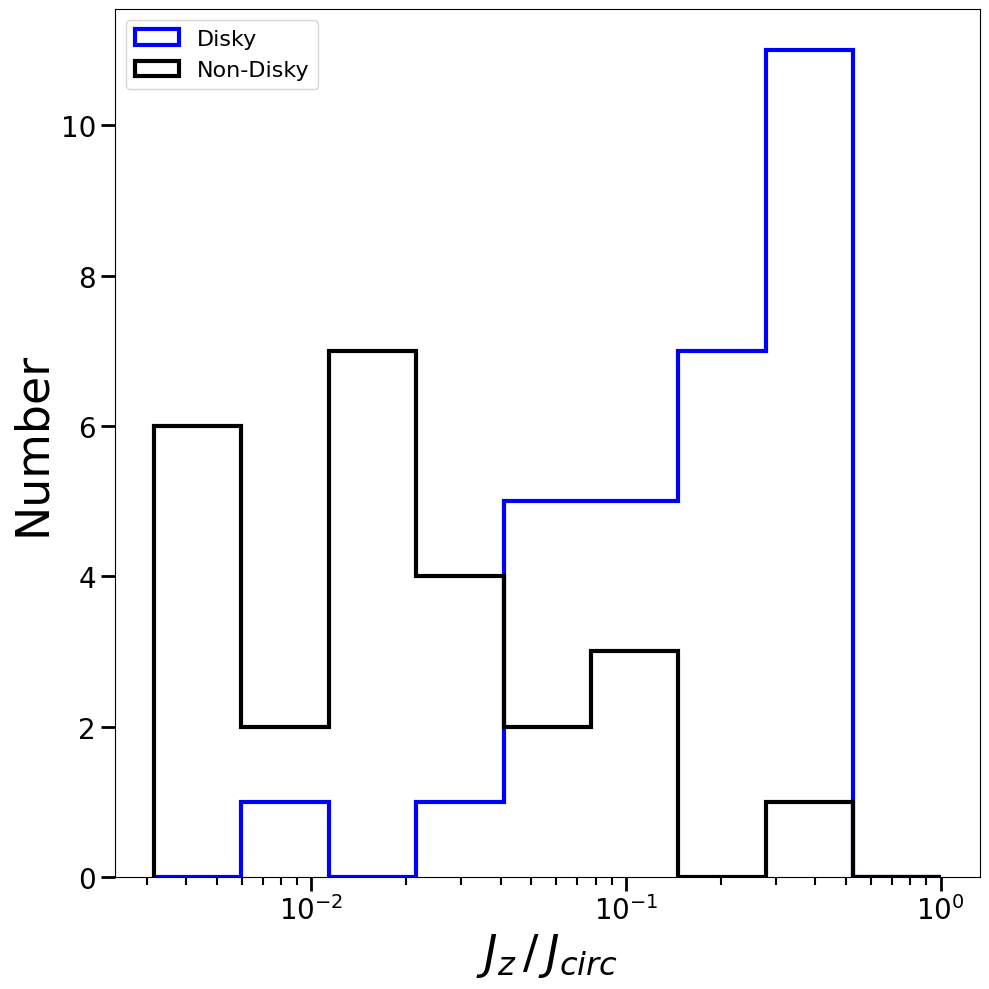

Combined plot saved.

Outliers:
Feedback: BWMDC, Simulation: storm, Halo ID: 31, Reason: jz_jcirc out of range: 1603.3889815340751, classification: Non-Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 2, Reason: jz_jcirc out of range: 11293.603801718218, classification: Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 3, Reason: jz_jcirc out of range: 600718.6679464484, classification: Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 4, Reason: jz_jcirc out of range: 258.64951587130605, classification: Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 23, Reason: jz_jcirc out of range: 1079.8149239426032, classification: Non-Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 27, Reason: jz_jcirc out of range: -423.8648342047455, classification: Non-Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 38, Reason: jz_jcirc out of range: 5796.555742842233, classification: Non-Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 65, Reason: jz_jcirc out of range: 509.1509724191755, classificat

In [30]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import traceback

# Function to load data
def load_data(feedback):
    with open(f'galaxy_classifications_{feedback}-v2.pickle', 'rb') as f:
        classifications = pickle.load(f)

    with open(f'../../Data/BasicData/{feedback}.Masses.pickle', 'rb') as f:
        masses = pickle.load(f)

    return classifications, masses

# Function to handle outliers
def handle_outliers(df, jz_jcirc_min=-10, jz_jcirc_max=10):
    outliers = []

    for index, row in df.iterrows():
        if not (jz_jcirc_min <= row['jz_jcirc'] <= jz_jcirc_max):
            outliers.append({
                'feedback': row['feedback'],
                'sim': row['sim'],
                'hid': row['hid'],
                'reason': f"jz_jcirc out of range: {row['jz_jcirc']}",
                'classification': row['classification']
            })
            df.at[index, 'jz_jcirc'] = np.nan

    return df, outliers

# Function to process data
def process_data(classifications, masses, feedback, jz_jcirc_min=-10, jz_jcirc_max=10):
    data = []
    for sim in classifications:
        for hid, class_ in classifications[sim].items():
            if str(hid) in masses[sim]:
                halo_data = masses[sim][str(hid)]
                jz_jcirc = float(halo_data['jz_jcirc_avg'])

                # Combine 'e' and 'i' into 'Non-Disky'
                classification = 'Disky' if class_ == 'd' else 'Non-Disky'

                data.append({
                    'feedback': feedback,
                    'sim': sim,
                    'hid': hid,
                    'classification': classification,
                    'jz_jcirc': jz_jcirc,
                    'j_crit': halo_data['j_crit'],
                    'dt_star': halo_data['dt_star'],
                    'dt_gas': halo_data['dt_gas'],
                    'dt_total': halo_data['dt_total'],
                    #'stellar_mass': halo_data['stellar_mass'],

                })

    df = pd.DataFrame(data)
    df, outliers = handle_outliers(df, jz_jcirc_min, jz_jcirc_max)
    return df, outliers

# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

def create_plot(df, y_column, output_filename):
    #clear previous plot
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    #matplotlib defualts


    labels = ['Disky', 'Non-Disky']
    colors = ['blue', 'black']

    bin_edges = np.logspace(-2.5, 0, 10)
    #print(bin_edges)

    #count any data points with jz_jcirc < 10^-3 to 10^-3
    print('Number of data points with jz_jcirc < 10^-2.5')
    print(df[df['jz_jcirc'] < 10**-2.5][y_column].count())


    # Get absolute value of jz_jcirc
    df['jz_jcirc'] = df['jz_jcirc'].abs()

    for label, color in zip(labels, colors):
        #print(color, label)
        #print(df[df['classification'] == label][y_column])

        ax.hist(df[df['classification'] == label][y_column],
                bins=bin_edges,
                color=color,
                edgecolor=color,
                linewidth=3,
                label=label,
                density=False,
                histtype='step')

    ax.set_xlabel(r'$J_z \,/\, J_{circ}$', fontsize=33)
    ax.set_ylabel('Number', fontsize=33)
    ax.set_xscale('log')

    #increase size of tick labels
    ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)
    #increase size of subticks
    ax.tick_params(axis='both', which='minor', labelsize=5, width=1.5, length=6)
    ax.legend(fontsize=16)

    plt.tight_layout()
    plt.savefig(output_filename, bbox_inches='tight')
    plt.show()


# Main execution
feedbacks = ['BWMDC', 'MerianCDM']

# Adjustable parameters for outlier removal
JZ_JCIRC_MIN = -10
JZ_JCIRC_MAX = 10

# Adjustable y-axis limit
y_limit = (-0.1, 0.5)

all_data = []
all_outliers = []

for feedback in feedbacks:
    print(f"Processing {feedback}...")
    classifications, masses = load_data(feedback)
    df, outliers = process_data(classifications, masses, feedback, JZ_JCIRC_MIN, JZ_JCIRC_MAX)

    all_data.append(df)
    all_outliers.extend(outliers)

    print(f"Data summary for {feedback}:")
    print(df.describe())

df = pd.concat(all_data, ignore_index=True)

df['jz_jcirc/j_crit'] = (df['jz_jcirc'] / df['j_crit'])

#create_plot(df, 'jz_jcirc', f'/home/bk639/OverLeaf/ShapePaper/jz_jcirc.png')
create_plot(df, 'jz_jcirc', f'../../Figures/PaperFigures/jz_jcirc.png')

print("Combined plot saved.")

print("\nOutliers:")
for outlier in all_outliers:
    print(f"Feedback: {outlier['feedback']}, Simulation: {outlier['sim']}, Halo ID: {outlier['hid']}, Reason: {outlier['reason']}, classification: {outlier['classification']}")

print("Plot created successfully.")